##Importing Packages

In [ ]:
import scipy.io
import os
!pip install dgl
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.data import DGLDataset
from sklearn import metrics

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.4 MB 14.5 MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


transferring matlab data to a .csv could allow for easier loading of the data. Especially the survival stats

## Loading Data

In [ ]:
os.getcwd()
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
os.listdir()


['Untitled0.ipynb',
 'my_chi2.ipynb',
 '1_introduction.py',
 '1_introduction.ipynb',
 'UHpat400_withPts3.mat',
 'Copy of Copy of dgcnn-graph-classification.ipynb',
 'UHpat400_withPts2.mat',
 'UHpat400_withPts.mat',
 't2.mat',
 't1.mat',
 't3.mat',
 'Tensorflow Crash Course',
 '6_load_data.ipynb',
 'kerasHyperParameterTuning.ipynb',
 'UHpat60k1.mat',
 't60.mat',
 'Copy of kerasHyperParameterTuning.ipynb',
 'OLD MACE',
 'Basic MACE.ipynb',
 'Learning DGL.ipynb',
 'GNN Techniques.gslides',
 'LoadingADataset.ipynb',
 'Loading MACE.ipynb']

Practice data set if needed

## Creating Graphs and Dataset

Graph(num_nodes=20, num_edges=39,
      ndata_schemes={'h': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'DistTop2Lesion': Scheme(shape=(), dtype=torch.float64)}) tensor([1], dtype=torch.uint8)


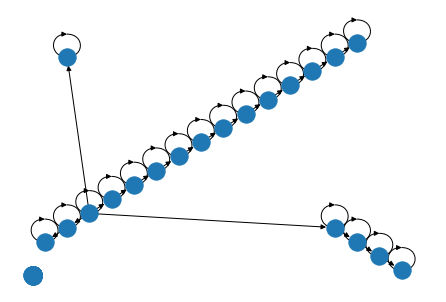

In [ ]:
class MACEDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='MACE')

    def process(self):
        MACEData=[scipy.io.loadmat('UHpat400_withPts.mat',squeeze_me=True), scipy.io.loadmat('UHpat400_withPts2.mat',squeeze_me=True), scipy.io.loadmat('UHpat400_withPts3.mat',squeeze_me=True),scipy.io.loadmat('UHpat60k1.mat',squeeze_me=True)]
        # edges = pd.read_csv('./graph_edges.csv')
        # properties = pd.read_csv('./graph_properties.csv')
        self.graphs = []
        self.labels = []
        self.Adj=[]
        self.pos=[]
        self.dim_nfeats = 0
        self.gclasses=1

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for k in range(4):
          ICMore=MACEData[k]['ICmore']
          if k==0:
            t=scipy.io.loadmat('t1.mat',squeeze_me=True)['x']
          if k==1:
            t=scipy.io.loadmat('t2.mat',squeeze_me=True)['x']
          if k==2:
            t=scipy.io.loadmat('t3.mat',squeeze_me=True)['x']
          if k==3:
            t=scipy.io.loadmat('t60.mat',squeeze_me=True)['x']
          length=len(ICMore)
          Artery_Label=np.empty([1,length+1])
          grlib=np.empty(length+1)
          for i in range(length):
            x=ICMore[i]
            y=x.tolist()
            if k==3:
              z=y[-2]
            else:
              z=y[-1]
            a=z.tolist()
            Artery_Label=np.asarray(a[1])
            t2l=np.asarray(a[-1]).reshape(-1)
            l2l=np.asarray(a[-1]).reshape(-1)
            #eignevalues!!!
            header_list=0
            header_list=np.array([2,3,4,5,6,7,8])
            if k==3:
              header_list=header_list-2
            #head_feats=np.zeros([len(header_list),len(Artery_Label)])
            head_feats=[y[h] for h in header_list]
            label_dict = {}
            num_nodes_dict = {}
            #Adj=np.zeros([np.size(Artery_Label)+1,np.size(Artery_Label)+1])
            Adj=np.eye(np.size(Artery_Label)+1)-1
            #if np.size(Adj,0)>1:
            for j in range(6):
              artery=np.nonzero(j==Artery_Label)[0]
              if np.size(artery)!=0:
                Adj[artery[:-1],artery[1:]]=l2l[artery[:-1]]
                Adj[-1,artery[0]]=t2l[artery[0]]
            #Adj=np.transpose(Adj)
            #print(sum(sum(Adj)))
            #print(np.shape(Adj))
            #print(Adj)
            rows, cols = np.where(Adj >= 0)
            edges = zip(rows.tolist(), cols.tolist())
            g = dgl.graph((rows, cols), num_nodes=np.size(Artery_Label)+1)
            edges=g.edges()
            #print(len(cols))
            #print(g.edges())
            #print(np.asarray(a[-2]))
            if len(cols)==1 | np.size(np.asarray(a[-2]))==0:
                continue
            else:
                edge_norm=np.max(np.asarray(a[-2]))
                #print(torch.LongTensor(np.append(np.asarray(a[-1])/edge_norm*100,0)))
                #print(torch.mul(torch.LongTensor(np.append(np.asarray(a[-1],dtype=float)/edge_norm,0)),torch.LongTensor(Adj).float())*100)
                #print(torch.LongTensor(np.append(np.asarray(a[-1],dtype=float)/edge_norm,0)*Adj)*100)

                # top2 lesion preferred becasuse we cannot detect osteum now
                edgeweight=(edge_norm-np.asarray(a[-2]))/edge_norm*100
                #print(edgeweight)
                edgeweightself=np.ones([2*np.size(edgeweight)+1])
                #print(edgeweightself[1:-1:2])
                edgeweightself[1:-1:2]=edgeweight
                #print(edgeweightself)
                g.edata['DistTop2Lesion']=torch.tensor(Adj[rows,cols])
                #g.edata['DistTop2Lesion']=torch.tensor(edgeweightself).float()/100 #torch.mul(torch.LongTensor(np.append(np.asarray(a[-1],dtype=float)/edge_norm,0)),torch.LongTensor(Adj).float()) #
                feats=[0,2,8] #,11,12,19,20,21,23,-2]
                self.dim_nfeats=len(feats)#+len(header_list)
                norm=np.array([155.1,0,24.4,0,0,0,0,0,119.7])   #THIS IS HARD CODED FOR NOW REMEMBER THIS!!
                featarray=np.zeros([len(feats),np.size(a[0])+1,])
                qq=0
                for f in feats:
                  featarray[qq,:]=np.append(a[f]/norm[f],0)
                  qq=qq+1
            g.ndata['h']=torch.rot90(torch.tensor(featarray),1,[1,0]).float()
            #pos=np.append(np.asarray(a[10]),[[0],[0],[0]],axis=1)
            self.graphs.append(g)
            self.labels.append([t[i]])
            self.Adj.append(Adj)
            #self.pos.append(pos)
            
            

        # Convert the label list to tensor for saving.
        self.labels = torch.tensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = MACEDataset()
graph, label = dataset[0]
edges=graph.edges()
#pos=dataset.pos[-1][:-1]
nxgraph=dgl.to_networkx(graph)
viz = graphviz_layout(nxgraph, prog="twopi")
#print(dataset.Adj[-1])
#viz=dict(enumerate(np.transpose(pos), 0))
nx.draw(dgl.to_networkx(graph))
nx.draw(nxgraph,pos=viz)
print(graph, label)

In [ ]:
label

tensor([1], dtype=torch.uint8)

In [ ]:
graph.edata['DistTop2Lesion']

tensor([  0.0000,  18.6102,   0.0000,  15.2324,   0.0000,  14.7630,   0.0000,
         86.9142,   0.0000,   0.0000,  20.8902,   0.0000,   5.8628,   0.0000,
         84.6351,   0.0000,  18.1329,   0.0000,  76.8229,   0.0000,   3.8919,
          0.0000,   0.0000,  22.6101,   0.0000, 120.9823,   0.0000,   8.2021,
          0.0000,   0.0000,  27.4576,   0.0000,  70.0853,   0.0000,  18.6102,
         74.9455,  76.8229, 120.9823,   0.0000], dtype=torch.float64)

In [ ]:
graph.ndata['h']

tensor([[5.2733e+00, 5.4986e+00, 5.4263e+00],
        [4.3720e+00, 4.2481e+00, 4.4989e+00],
        [8.8137e-01, 8.2961e-01, 9.0694e-01],
        [1.5436e+00, 1.6764e+00, 1.5884e+00],
        [1.4441e-01, 1.1792e-01, 1.4860e-01],
        [3.4857e-02, 1.6405e-02, 8.9670e-03],
        [4.4318e-01, 5.5888e-01, 4.5603e-01],
        [1.1951e-01, 1.1450e-01, 1.2298e-01],
        [3.4857e-02, 1.6834e-02, 8.9670e-03],
        [1.3445e-01, 1.0678e-01, 1.3835e-01],
        [1.2449e-01, 9.7215e-02, 9.6075e-02],
        [4.9795e-02, 2.7874e-02, 2.5620e-02],
        [6.4734e-02, 3.9874e-02, 3.3306e-02],
        [1.2170e+01, 1.3910e+01, 1.2523e+01],
        [3.5354e-01, 2.9878e-01, 3.6380e-01],
        [7.9672e-02, 4.6662e-02, 4.0992e-02],
        [1.1373e+01, 1.0974e+01, 1.1703e+01],
        [1.1951e-01, 8.7753e-02, 9.2232e-02],
        [1.2299e+00, 1.5492e+00, 1.2656e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])

## Checking Behavior of Dataset

In [ ]:
graph, label = dataset[4]
dgl.function.max('m', 'ft')
dgl.function.u_mul_e('h', 'DistTop2Lesion', 'm')
graph.ndata['h'].dtype
#graph.update_all(dgl.function.u_mul_e('attr', 'DistTop2Lesion', 'm'),dgl.function.max('m', 'ft'))
#graph.ndata['attr']
dgl.max_nodes(graph, 'h').float()

tensor([[ 8.7873, 12.9621,  9.0422]])

In [ ]:
num_examples = len(dataset)
#t1=scipy.io.loadmat('t1.mat',squeeze_me=True)['x']
#t2=scipy.io.loadmat('t2.mat',squeeze_me=True)['x']
#t3=scipy.io.loadmat('t3.mat',squeeze_me=True)['x']
#t=[t1,t2,t3]*0.6+0.2
num_train = int(num_examples * 0.8)
#WeightedRandomSampler(t,num_examples * 0.8,replacement=False)

x=np.arange(0,len(dataset))
np.random.shuffle(x)
a=x[np.arange(num_train)]
b=x[torch.arange(num_train, num_examples)]

#sum(t)/len(t)

Make sure the split has same MACE no MACE ratio.

In [ ]:

from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler #, WeightedRandomSampler


train_sampler = SubsetRandomSampler(a)
test_sampler = SubsetRandomSampler(b)

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=10, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=10, drop_last=False)

In [ ]:
it = iter(train_dataloader)
batch = next(it)
#print(batch)

In [ ]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
#print('The original graphs in the minibatch:')
#print(graphs)

Number of nodes for each graph element in the batch: tensor([16, 21,  3, 16, 13, 14,  4,  3, 24, 16])
Number of edges for each graph element in the batch: tensor([31, 41,  5, 31, 25, 27,  7,  5, 47, 31])


In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.conv3 = GraphConv(h_feats, num_classes)
        self.classify = nn.Linear(h_feats, num_classes)
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = torch.relu(h)
        with g.local_scope():
          g.ndata['out'] = h 
          hg = dgl.mean_nodes(g, 'out') #aggreagate node features using MLP!!!!!!!!!!!!!!!!!!!!!
          #print(max(h),min(h))
          #g.update_all(dgl.function.u_mul_e('out1', 'DistTop2Lesion', 'm'),dgl.function.mean('m', 'out')) 
          #g.update_all(dgl.function.u_mul_e('out', 'DistTop2Lesion', 'm'),dgl.function.mean('m', 'out')) 
          #print(np.shape(h))
          #print(dgl.mean_nodes(g, 'out').float())
          
          return F.sigmoid(self.classify(hg)) #max nodes

increase number of intermediate nodes, consider gcdm optimizer. Consider making changes to learning rate. Learning rate is now based on previous example and number of epochs were decreased. grid search through different optimizers. run through different learning rates. kaplan meier curves

## Model Training

In [ ]:
#Cross Validation
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

num_epochs=100
train_acc=np.zeros([5,num_epochs])
auc=np.zeros([5,num_epochs])
test_acc=np.zeros([5,num_epochs])
train_loss=np.zeros([5,num_epochs])

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print('Fold',fold+1)
  print('---------------------------------')
  train_sampler = SubsetRandomSampler(train_ids)
  test_sampler = SubsetRandomSampler(test_ids)

  train_dataloader = GraphDataLoader(
      dataset, sampler=train_sampler, batch_size=50, drop_last=False)
  test_dataloader = GraphDataLoader(
      dataset, sampler=test_sampler, batch_size=50, drop_last=False)

  # Create the model with given dimensions
  model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
  optimizer = torch.optim.Adam(model.parameters(), lr=.001)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

  for epoch in range(num_epochs):
      batch_loss=[];
      train_num_correct = 0
      num_trains = 0
      preds=np.array([])
      labels=np.array([])
      for batched_graph, label in train_dataloader:
          pred = model(batched_graph, batched_graph.ndata['h'].float())
          train_preds= np.append(preds,pred.detach().numpy())
          train_num_correct += ((pred>0) == label).sum().item()
          labels = np.append(labels,label.detach().numpy())
          num_trains += len(label)
          #print(pred)
          #print(label)
          pred_class=torch.stack((1-pred,pred),dim=1)
          loss = F.binary_cross_entropy(pred,label.float()) 
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          scheduler.step()
          batch_loss.append(loss)
      train_loss[fold,epoch]=sum(batch_loss)/len(batch_loss)
      num_correct = 0
      num_tests = 0
      preds=np.array([])
      labels=np.array([])
      for batched_graph, label in test_dataloader:
          pred = model(batched_graph, batched_graph.ndata['h'].float())
          preds= np.append(preds,pred.detach().numpy())
          num_correct += ((pred>0.5) == label).sum().item()
          labels = np.append(labels,label.detach().numpy())
          num_tests += len(label)
      #fpr, tpr, thresholds=metrics.roc_curve(labels,preds)
      #auc[fold,epoch] = metrics.roc_auc_score(labels, preds)
      train_acc[fold,epoch]=train_num_correct / num_trains
      test_acc[fold,epoch]=num_correct / num_tests
      #print('Epoch:',epoch,'| train_loss',train_loss[fold,-1],'| train accuracy',train_num_correct / num_trains,'| Test accuracy:', num_correct / num_tests)

Fold 1
---------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Fold 2
---------------------------------
Fold 3
---------------------------------
Fold 4
---------------------------------
Fold 5
---------------------------------


## Model Results


Loss function needs to be changed
increase nodes and layers?

Text(0.5, 1.0, 'Train Loss per Epoch')

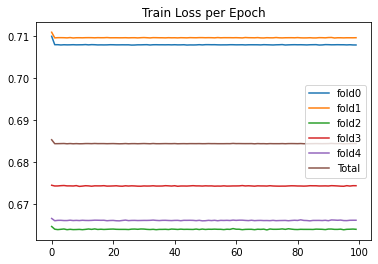

In [ ]:
for fold in range(5):  
  plt.plot(np.arange(0,num_epochs),train_loss[fold],label=('fold'+str(fold))) 
plt.plot(np.arange(0,num_epochs),np.mean(train_loss,0),label=('Total')) 
plt.legend()
plt.title('Train Loss per Epoch')
#2-fold validation
#10-fold validation

Text(0.5, 1.0, 'Train Accuracy per Epoch')

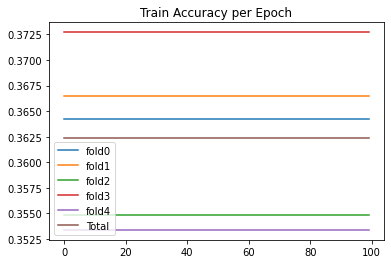

In [ ]:
for fold in range(5):  
  plt.plot(np.arange(0,num_epochs),train_acc[fold],label=('fold'+str(fold))) 
plt.plot(np.arange(0,num_epochs),np.mean(train_acc,0),label=('Total')) 
plt.legend()
plt.title('Train Accuracy per Epoch')

In [ ]:
sum(preds>0.5)

0

Text(0.5, 1.0, 'Test Accuracy per Epoch')

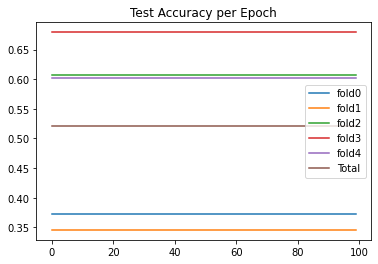

In [ ]:
for fold in range(5):  
  plt.plot(np.arange(0,num_epochs),test_acc[fold],label=('fold'+str(fold)))
plt.plot(np.arange(0,num_epochs),np.mean(test_acc,0),label=('Total'))  
plt.legend()
plt.title('Test Accuracy per Epoch')

In [ ]:
#graph.ndata.pop()
sum(labels)/len(labels)
for param in model.parameters():
   print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([3, 16])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 16])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])
<class 'torch.nn.parameter.Parameter'> torch.Size([1, 16])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])


roc analysis on training and testing

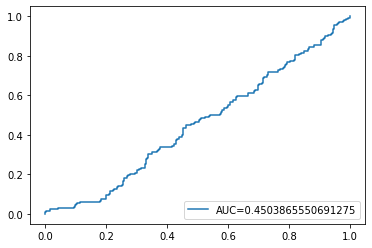

In [ ]:
fpr, tpr, thresholds=metrics.roc_curve(labels,preds)
auc = metrics.roc_auc_score(labels, preds)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
#print(labels,preds)

In [ ]:
fpr

array([0.        , 0.        , 0.        , 0.00296736, 0.00296736,
       0.0148368 , 0.0148368 , 0.02373887, 0.02373887, 0.04154303,
       0.04154303, 0.09495549, 0.09495549, 0.09792285, 0.09792285,
       0.10089021, 0.10089021, 0.10385757, 0.10385757, 0.11275964,
       0.11275964, 0.17210682, 0.17210682, 0.1810089 , 0.1810089 ,
       0.18397626, 0.18397626, 0.19881306, 0.19881306, 0.20771513,
       0.20771513, 0.21364985, 0.21364985, 0.21661721, 0.22255193,
       0.22255193, 0.22551929, 0.22551929, 0.23442136, 0.23442136,
       0.24035608, 0.24035608, 0.24332344, 0.24332344, 0.25222552,
       0.25222552, 0.25519288, 0.25519288, 0.25519288, 0.25816024,
       0.25816024, 0.25816024, 0.2611276 , 0.2611276 , 0.26706231,
       0.26706231, 0.27299703, 0.27299703, 0.27893175, 0.27893175,
       0.28783383, 0.29376855, 0.29376855, 0.30267062, 0.30267062,
       0.30860534, 0.30860534, 0.31454006, 0.31454006, 0.3264095 ,
       0.3264095 , 0.32937685, 0.32937685, 0.32937685, 0.33234

In [ ]:
accs=np.zeros([100,1])
thr=np.linspace(0,1,100)
for thr in range(100):
  accs[thr]=((preds>thr/100) == labels).sum().item()/len(labels)

thr=np.linspace(0,1,101)
val=np.max(accs)
ind=np.argmax(accs)
print('Optimal Threshold: ',thr[ind])
print('Accuracy: ',val)

Optimal Threshold:  0.46
Accuracy:  0.6017857142857143


In [ ]:
label.float()

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])

**First attempt at MPNN**

import torch
import torch.nn as nn
from torch.nn import Parameter
import dgl.function as fn

class NNConvLayer(nn.Module):
    def __init__(self,
                 g,
                 in_channels,
                 out_channels,
                 edge_net,
                 aggr='add',
                 root_weight=True,
                 bias=True):
        super(NNConvLayer, self).__init__()
        
        self.g = g
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_net = edge_net
        self.aggr = aggr

        if root_weight:
            self.root = Parameter(torch.Tensor(in_channels, out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()
        
    
    def reset_parameters(self):
        if self.root is not None:
            nn.init.xavier_normal_(self.root.data, gain=1.414)
        if self.bias is not None:
            self.bias.data.zero_()
        for m in edge_net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data, gain=1.414)
                
    def message(self, edges):
        return {'m' : torch.matmul(edges.src['h'].unsqueeze(1),edges.data['w']).squeeze(1)}
    
    def reduce(self, nodes):
        if self.aggr == 'add':
            return {'aggr_out' : torch.sum(nodes.mailbox['m'], 1)}
        elif self.aggr == 'mean':
            return {'aggr_out' : torch.mean(nodes.mailbox['m'], 1)}
        else:
            raise AssertionError()
            
    def apply_node_func(self, nodes):
        aggr_out = nodes.data['aggr_out']        
        if self.root is not None:
            aggr_out = torch.mm(nodes.data['h'], self.root) + aggr_out
        
        if self.bias is not None:
            aggr_out = aggr_out + self.bias   
        
        return {'h': aggr_out}

    def forward(self, h, e):
        #h = h.unsqueeze(-1) if h.dim() == 1 else h
        e = e.unsqueeze(-1) if e.dim() == 1 else e
        
        self.g.ndata['h'] = h
        self.g.edata['w'] = self.edge_net(e).view(-1, self.in_channels, self.out_channels)
        
        if self.aggr == 'add':
            g.update_all(self.message, self.reduce,self.apply_node_func)
        elif self.aggr == 'mean':
            
            g.update_all(self.message, self.reduce, self.apply_node_func)

        return self.g.ndata.pop('h')

**MPNN from Internet**